In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
current_directory = os.getcwd()
while current_directory.endswith("Notebooks"):
    os.chdir("..")
    current_directory = os.getcwd()
    print("Current working directory: ", current_directory)

Current working directory:  c:\Users\thomaswi\OneDrive - SINTEF\Drilling and well\Code\CodeForMaster


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
from utils.filepaths.filepaths import (
    FILE_PATH_CASE_101,
    FILE_PATH_CASE_101_HFM_T,
    FILE_PATH_CASE_101_HFM_T_OBS,
    FILE_PATH_CASE_101_HFM_Z,
    RHEOLOGY_DATA_CASE_101_PATH,
    FILE_PATH_TRANSIENT_TRAINING_DATA_101_FEATURES,
    FILE_PATH_TRANSIENT_TRAINING_DATA_101_TARGETS,
    FILE_PATH_TRANSIENT_OTHER_VARIABLES_101
)

from utils.utils.utils import (
    get_active_drilling_data,
    reading_labeled_drill_report_data,
    extracting_labeled_data_from_dataframe,
    plot_sections,
    map_pars_t_z,
    extract_time_series_from_depth_data_for_given_variables,
    get_herschel_bulkley_parameters_from_rheology_file,
    get_training_dataset_from_field_data_transients
)

sns.set_theme()

In [4]:
# Loading files
sensor_data_case_102 = pd.read_pickle(FILE_PATH_CASE_101)
# Extracting the dates to consider
tstamp_min = '2020-07-23 02:45:00+00:00'
tstamp_max = '2020-07-25 02:30:00+00:00'
sensor_data_case_102 = sensor_data_case_102.loc[tstamp_min:tstamp_max]
# First datapoint was removed during pickling of simdata. Have to so the same here
sensor_data_case_102 = sensor_data_case_102.iloc[1:] 
hfm_data_case_102_t = pd.read_pickle(FILE_PATH_CASE_101_HFM_T)
hfm_data_case_102_t_obs = pd.read_pickle(FILE_PATH_CASE_101_HFM_T_OBS)
hfm_data_case_102_z = pd.read_pickle(FILE_PATH_CASE_101_HFM_Z)


In [5]:
# Getting the indices for the model data right
start_date = '2020-07-23 02:45:00+00:00'
date_range = pd.date_range(start = start_date, periods = len(hfm_data_case_102_t), freq='10s')
hfm_data_case_102_t.index = date_range
# hfm_data_case_102_t_obs.index = date_range
hfm_data_case_102_t.head()
hfm_data_case_102_t.columns

Index(['Rate_in', 'SPP', 'ECD_bot', 'ECD_shoe', 'P_choke', 'FrontFluid2',
       'FrontFluid3', 'FrontFluid4', 'FrontFluid5', 'FrontFluid6', 'totVolInj',
       'totStrokes', 'totVolOut', 'pitVol', 'WHP', 'volRateOut', 'dsGap',
       'BHP', 'T_bot', 'T_top', 'mdBit', 'ecdAtPos', 'pAtPos', 'TAtPos',
       'dsRpm', 'rop', 'xFactor', 'kFactor', 'yCalc', 'yCalcAvg', 'yMeas',
       'Pxy', 'Pyy', 'Pa', 'Gel1', 'Gel2', 'Gel3', 'Gel4', 'Gel5', 'ShieldBHA',
       'ShieldAnn', 'ShieldRiser', 'CtrBHA', 'CtrAnn', 'CtrRiser',
       'CutConsBHA', 'CutConsAnn', 'CutConsRiser', 'ReynBHA', 'ReynAnn',
       'ReynRiser', 'TaylBHA', 'TaylAnn', 'TaylRiser', 'RouseBHA', 'RouseAnn',
       'RouseRiser', 'voidShoe', 'voidAtBha', 'cutSt', 'vDev', 'pDev',
       'mTotMud', 'mFreeGas', 'mDGas', 'qLoss', 'mLost', 'XFactor',
       'DSXFactor', 'DensityIn', 'DensityOut', 'incl'],
      dtype='object')

In [6]:
print(len(sensor_data_case_102), len(hfm_data_case_102_t))
sensor_data_case_102.head()

17190 17190


,ASMDEP1-T,ASMECD1-T,ASMDEP2-T,ASMECD2-T,ASMDEP3-T,ASMDOFF-T,DHT001 Temp PCB Mean,ASMTVD1-T,ASMTVD2-T,ASMTVD3-T,...,RPMPerStand,TqavPerStand,WOBRotPerStand,WOBPerStand,TqavPerStandRot,FlowPerStand,RPMPerStandRot,RDGDTVSS-Relog,AllSlidingRopPerStand,TqavPerStandSl
TIME,,,,,,,,,,,,,,,,,,,,,
2020-07-23 02:45:10+00:00,272.810000,1.332205,-613.861429,1.451468,-1385.245000,-184.820007,16.0,272.789998,0.36,0.45,...,12.32,21316.99,4906.12,4906.12,21316.99,0.04,12.32,80.0,52.33,46742.43
2020-07-23 02:45:20+00:00,272.810000,1.332205,-613.850000,1.451468,-1385.230000,-184.820007,16.0,272.789998,0.36,0.45,...,12.32,21316.99,4906.12,4906.12,21316.99,0.04,12.32,80.0,52.33,46742.43
2020-07-23 02:45:30+00:00,272.823333,1.332205,-613.846667,1.451468,-1385.225000,-184.820007,16.0,272.803324,0.36,0.45,...,12.32,21316.99,4906.12,4906.12,21316.99,0.04,12.32,80.0,52.33,46742.43
2020-07-23 02:45:40+00:00,272.842500,1.332205,-613.825000,1.451468,-1385.206667,-184.820007,16.0,272.822495,0.36,0.45,...,12.32,21316.99,4906.12,4906.12,21316.99,0.04,12.32,80.0,52.33,46742.43
2020-07-23 02:45:50+00:00,272.862500,1.332205,-613.803333,1.451468,-1385.185000,-184.820007,16.0,272.842499,0.36,0.45,...,12.32,21316.99,4906.12,4906.12,21316.99,0.04,12.32,80.0,52.33,46742.43


In [7]:

# sensor_data_case_102, hfm_data_case_102_t = get_active_drilling_data(sensor_data_case_102, hfm_data_case_102_t, include_rop_zeros=True)
# Wait to get obs data. Not sure if it is necassary
# hfm_data_case_102_t_obs = hfm_data_case_102_t_obs.loc[hfm_data_case_102_t.index]

In [8]:
print(len(sensor_data_case_102), len(hfm_data_case_102_t),len(hfm_data_case_102_t_obs))
hfm_data_case_102_t.index = sensor_data_case_102.index
hfm_data_case_102_t_obs.index = sensor_data_case_102.index

17190 17190 17190


In [9]:
min_depth = 0 
max_depth = 5820

depth_data =  hfm_data_case_102_z[0]
depth_data_columns = hfm_data_case_102_z[1]

In [10]:
depth_data.shape

(18, 17190, 389)

In [11]:
asm_sensor_1 = sensor_data_case_102["ASMDEP1-T"]


In [12]:
values_for_position = extract_time_series_from_depth_data_for_given_variables(depth_data=depth_data, position_for_time_series=asm_sensor_1.values,columns=depth_data_columns)

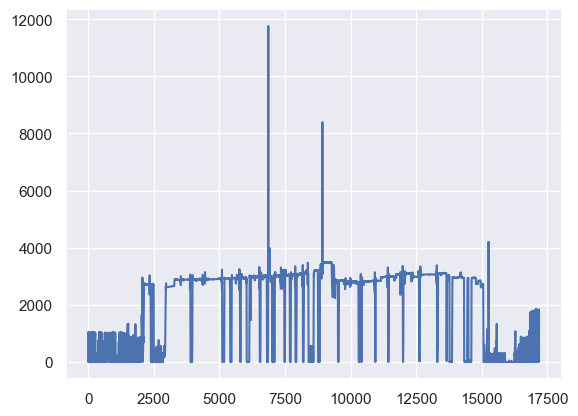

In [13]:
plt.plot(values_for_position["reyn"])
plt.show()

In [14]:

# m / s^2
gravitational_constant = 9.80
# m
DH = 0.06985
# m
charecteristic_length = 0
liquid_velocities = values_for_position["vL"]
pressure_gradient = values_for_position["dpf"]
# Unsure if this densisty value is the correct one
fluid_density = values_for_position["avgDensity"]
pressure = values_for_position["pOut/pBar"]
# Value blows up when there is little flow. Don't think this will be a problem during steady state conditions
fanning = DH * pressure_gradient / (2 * fluid_density * liquid_velocities**2)
values_for_position["Friction factor"] = fanning


C:\Users\thomaswi\AppData\Local\Temp\ipykernel_13584\3727425899.py:13: RuntimeWarning: divide by zero encountered in divide
  fanning = DH * pressure_gradient / (2 * fluid_density * liquid_velocities**2)


In [15]:
inclination = np.arccos(hfm_data_case_102_t_obs["TvdAtPpos1"].diff() /  hfm_data_case_102_t["mdBit"].diff()) * 180 / np.pi

c:\Users\thomaswi\AppData\Local\miniconda3\envs\master_thesis\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


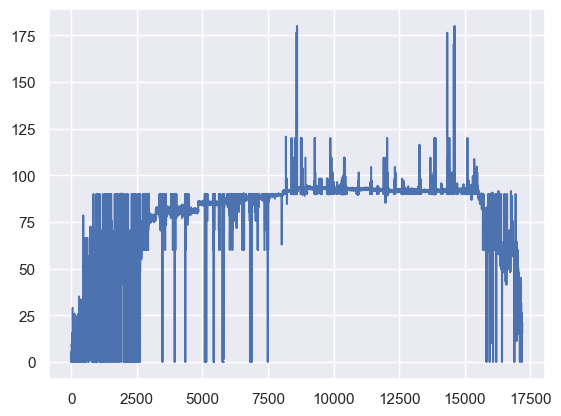

In [16]:
# Visual inspection provides us with the knowledge that the inclination is 
# 90 degrees during the entire drilling operation

plt.plot(inclination.values)


In [17]:
# These are the transients
indices_case_102 = [2622, 9033]

In [18]:
values_for_position_df = pd.DataFrame(values_for_position)
values_for_position_df.index = sensor_data_case_102.index
_, df_simulated = get_active_drilling_data(sensor_data_case_102, sim_df=hfm_data_case_102_t_obs, include_rop_zeros= True)
drilling_sensor_data_case_102, values_for_position_df = get_active_drilling_data(sensor_data_case_102, sim_df=values_for_position_df ,include_rop_zeros=True)

In [19]:
print(len(drilling_sensor_data_case_102))

10608


In [20]:
hb_parameters = get_herschel_bulkley_parameters_from_rheology_file(RHEOLOGY_DATA_CASE_101_PATH) 
hb_parameters.head(11)    

,Temperature,Pressure,Consistency index (K),Yield stress (tau_y),Flow behaviour index (n)
0,50.0,1.0,0.958735,0.044013,0.873375
1,50.0,103.0,1.185470,0.027074,0.960688
2,70.0,138.0,1.414590,0.037418,0.895384
3,70.0,172.0,1.410800,0.039181,0.896108
4,100.0,207.0,1.718600,0.049447,0.850131
5,100.0,241.0,1.653350,0.038693,0.893673
6,120.0,276.0,1.592610,0.048652,0.845525
7,120.0,310.0,1.544660,0.035205,0.895552
8,120.0,345.0,1.407300,0.034718,0.887522
9,120.0,414.0,1.391150,0.033585,0.901169


In [21]:
values_for_position_df.head()
yield_stress = []
consistency_index = []
flow_behaviour_index = []
temperature_regions = values_for_position_df["TOut"].apply(lambda x: 1 if x > 60 else 0)
hb_parameters_for_case = np.array([hb_parameters.loc[2] if t_region == 1 else hb_parameters.loc[1] for t_region in temperature_regions])

print('Min and max temp: ',values_for_position_df["TOut"].min(),values_for_position_df["TOut"].max())
print('Min and max pressure: ',values_for_position_df["pOut/pBar"].min(),values_for_position_df["pOut/pBar"].max()) 

print(len(liquid_velocities))
print(len(hb_parameters_for_case))
    

Min and max temp:  73.45076470588235 89.20099999999996
Min and max pressure:  268.18 347.03
17190
10608


In [22]:
# Adding new parameters and interaction terms
values_for_position_df["Bingham number"]= np.array([hb_parameters_for_case[idx,-2] /(hb_parameters_for_case[idx,-3] * (2*U/DH)**hb_parameters_for_case[idx,-1]) for idx, U in enumerate(values_for_position_df["vL"])])

C:\Users\thomaswi\AppData\Local\Temp\ipykernel_13584\1973994747.py:2: RuntimeWarning: invalid value encountered in power
  values_for_position_df["Bingham number"]= np.array([hb_parameters_for_case[idx,-2] /(hb_parameters_for_case[idx,-3] * (2*U/DH)**hb_parameters_for_case[idx,-1]) for idx, U in enumerate(values_for_position_df["vL"])])


In [23]:
# The annulus is assumed fully conccentric when inclination is 90 degrees
variables_1 = ["reyn","tayl","Bingham number","Friction factor", "rouseNum", "shieldsNum"]
variables = variables_1
training_features, training_targets,other_variables = get_training_dataset_from_field_data_transients(df=values_for_position_df,df_simulated=df_simulated, df_sensor = drilling_sensor_data_case_102,target = "ASMECD1-T",variables=variables, indices = indices_case_102, window = 20)


(2, 40, 6)
(2, 40, 6)


[Text(1.34220814704895, 0, '1.3422'),
 Text(1.3437602818012238, 0, '1.3438'),
 Text(1.3453124165534975, 0, '1.3453'),
 Text(1.3468645513057715, 0, '1.3469'),
 Text(1.3484166860580453, 0, '1.3484'),
 Text(1.349968820810319, 0, '1.3500'),
 Text(1.3515209555625929, 0, '1.3515'),
 Text(1.3530730903148667, 0, '1.3531'),
 Text(1.3546252250671407, 0, '1.3546'),
 Text(1.3561773598194145, 0, '1.3562'),
 Text(1.3577294945716882, 0, '1.3577')]

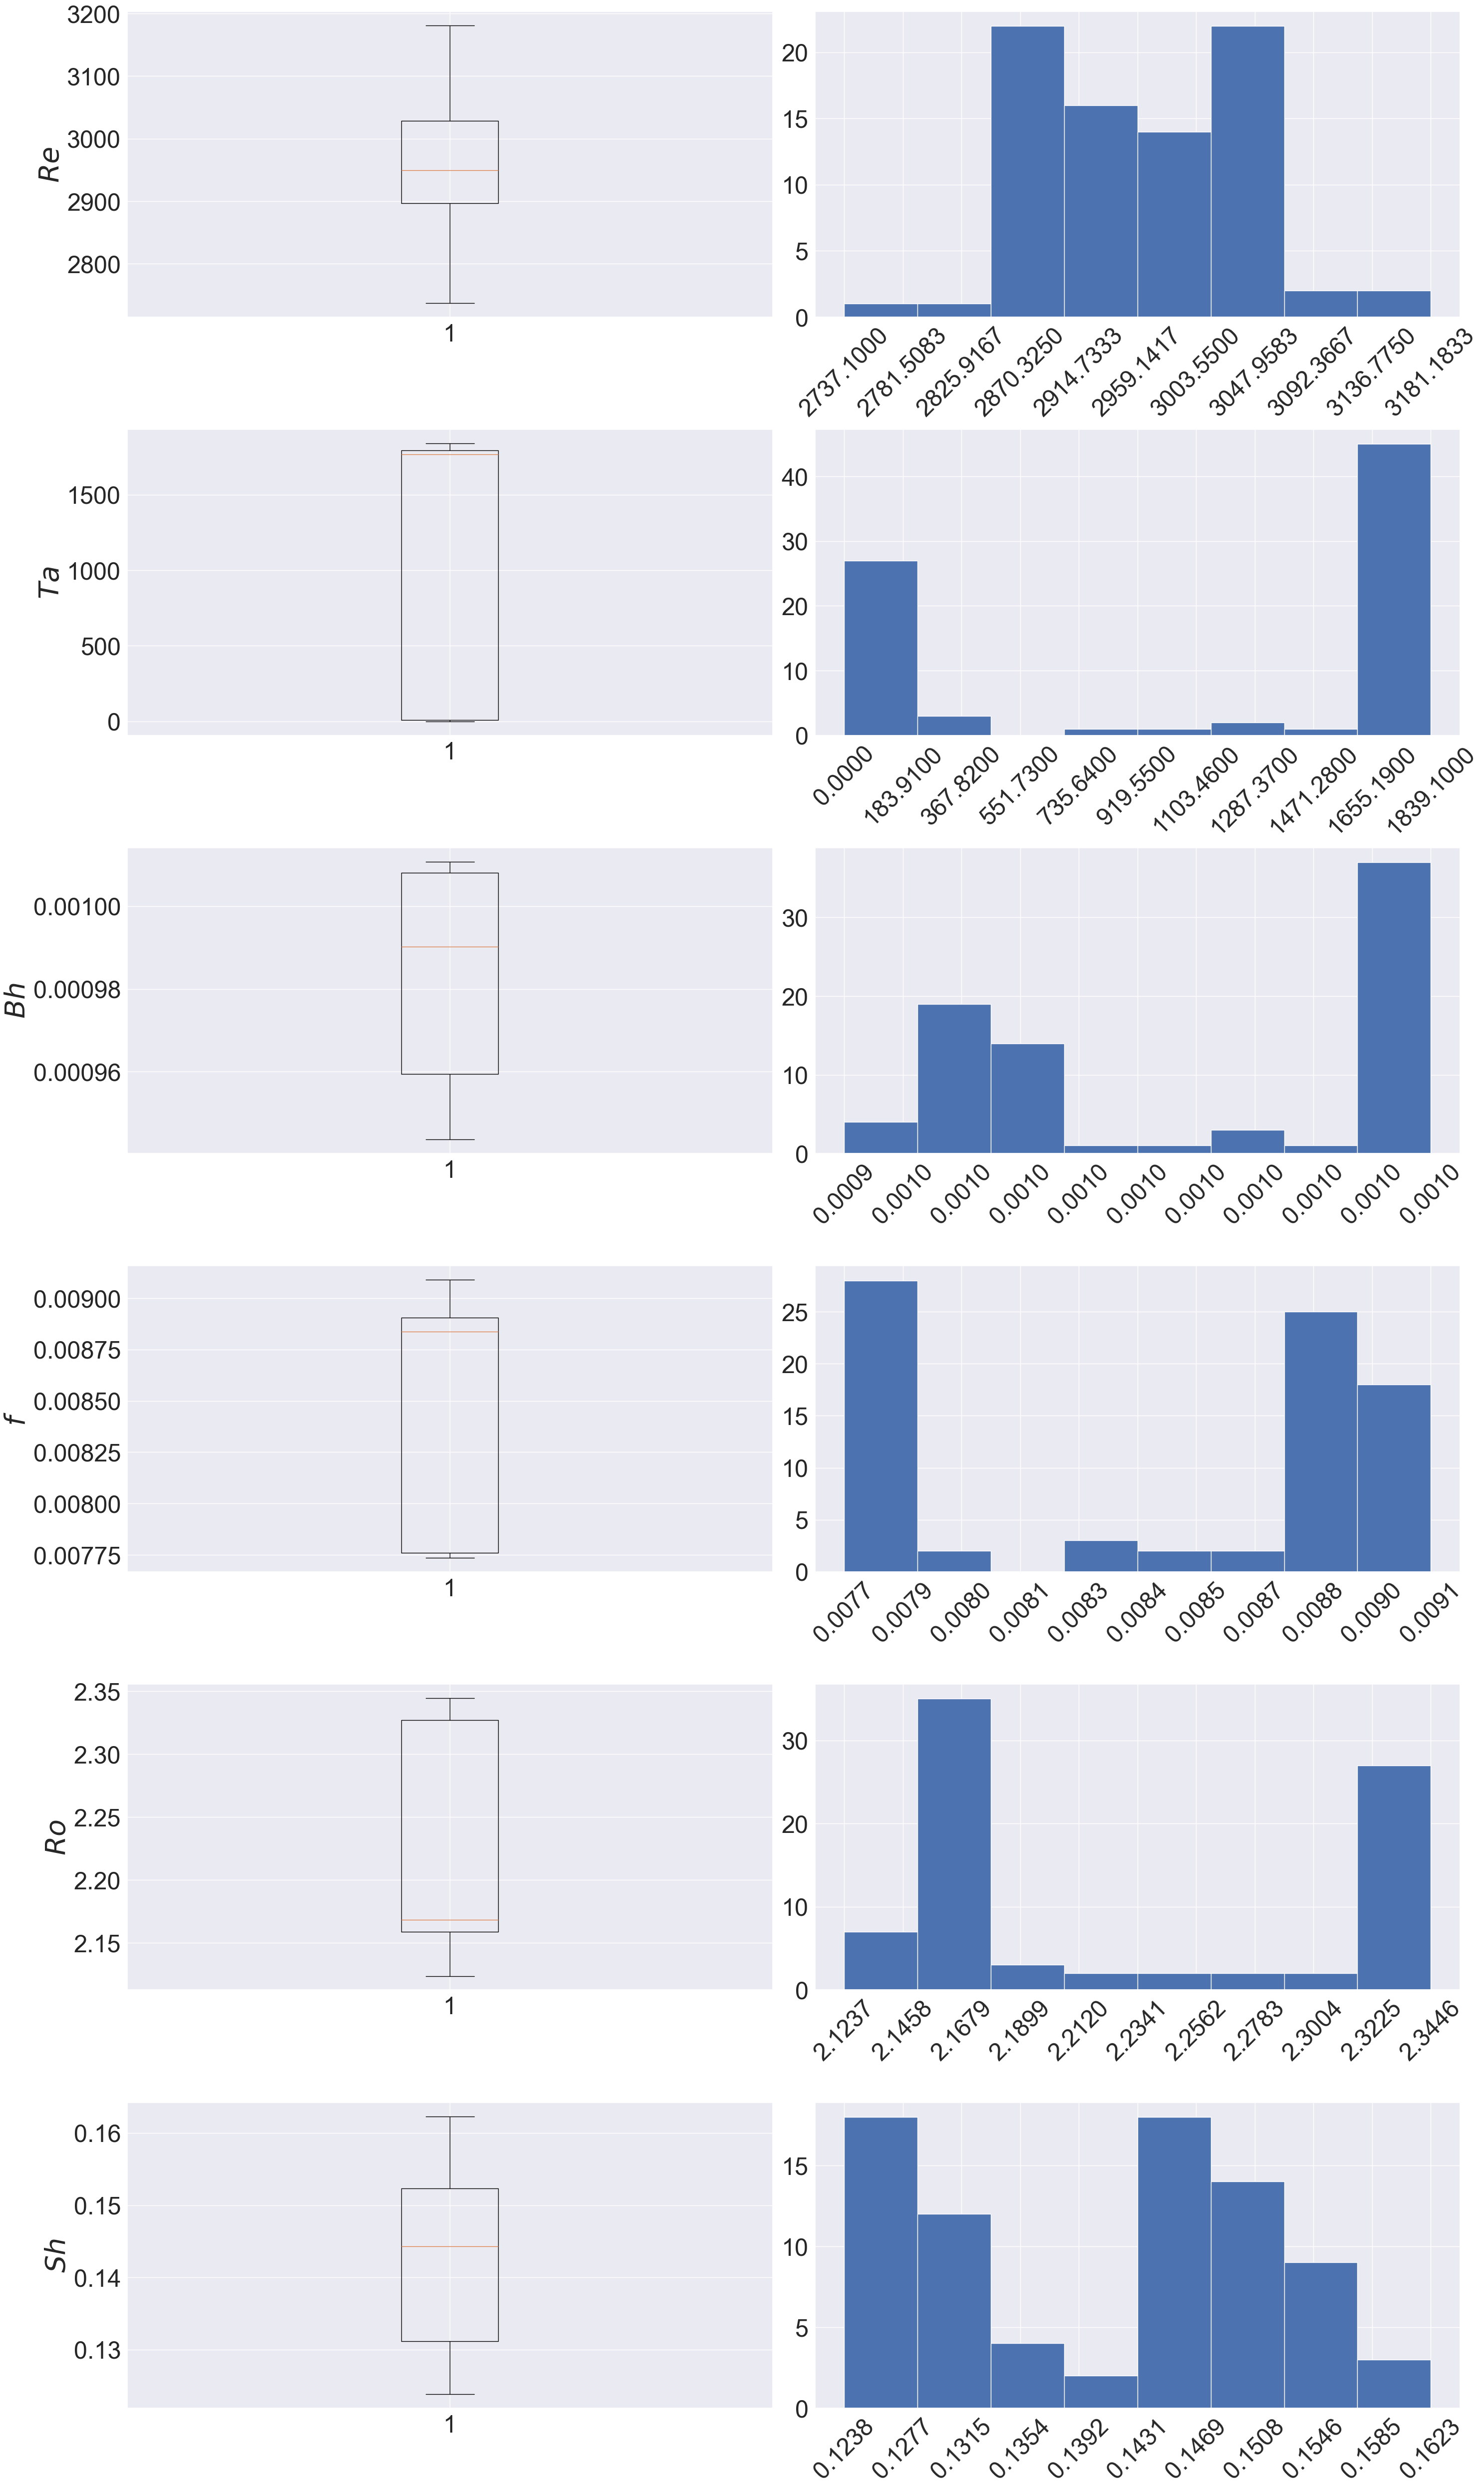

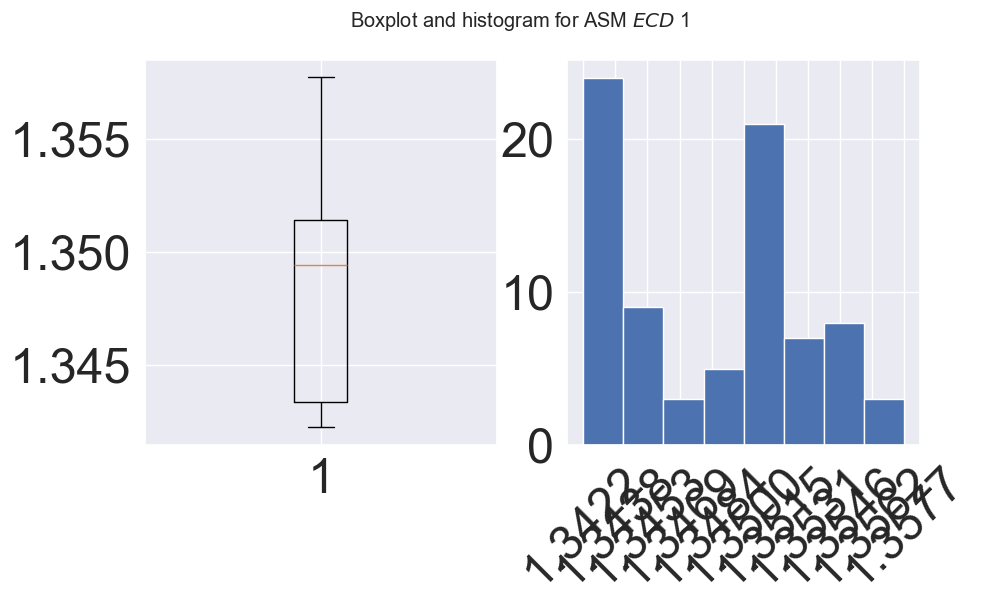

In [27]:
fig, ax = plt.subplots(training_features.shape[-1],2, figsize = (30,50))
plt.rcParams.update({
                     'xtick.labelsize': 35,  # X-axis tick labels
                     'ytick.labelsize': 35})  # Y-axis tick labels
variables_for_plot = ["$Re$", "$Ta$","$Bh$","$f$","$Ro$","$Sh$"]
print(training_features.shape)
all_features_reshaped = training_features.reshape(training_features.shape[0] * training_features.shape[1], training_features.shape[-1])
all_targets_reshaped = training_targets.reshape(training_targets.shape[0] * training_targets.shape[1])
x_axis_for_plot = np.arange(0, len(all_features_reshaped), 1)
np.random.shuffle(all_features_reshaped)
print(training_features.shape)
# axes = [ax[idx].scatter(np.arange(0,len(training_features[idx,:]),1),training_features[idx,:]) for idx in range(len(training_features))]
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))
for i in range(training_features.shape[-1]):
    ax[i,0].set_ylabel(variables_for_plot[i],fontsize = 40)
    # ax[i].scatter(x_axis_for_plot, all_features_reshaped[:,i])
    ax[i,0].boxplot(all_features_reshaped[:,i])
    ax[i,1].hist(all_features_reshaped[:,i], bins = 'auto')
    bin_edges = np.linspace(all_features_reshaped[:,i].min(), all_features_reshaped[:,i].max(), 11)
    rounded_labels = [f"{edge:.4f}" for edge in bin_edges]
    ax[i,1].set_xticks(bin_edges)
    ax[i,1].set_xticklabels(rounded_labels, rotation=45)
plt.tight_layout()
fig, ax = plt.subplots(1,2, figsize = (10,5))
fig.suptitle("Boxplot and histogram for ASM $ECD$ 1")
ax[0].boxplot(all_targets_reshaped)
ax[1].hist(all_targets_reshaped,bins = 'auto')
bin_edges = np.linspace(all_targets_reshaped.min(), all_targets_reshaped.max(), 11)
rounded_labels = [f"{edge:.4f}" for edge in bin_edges]
ax[1].set_xticks(bin_edges)
ax[1].set_xticklabels(rounded_labels, rotation=45)

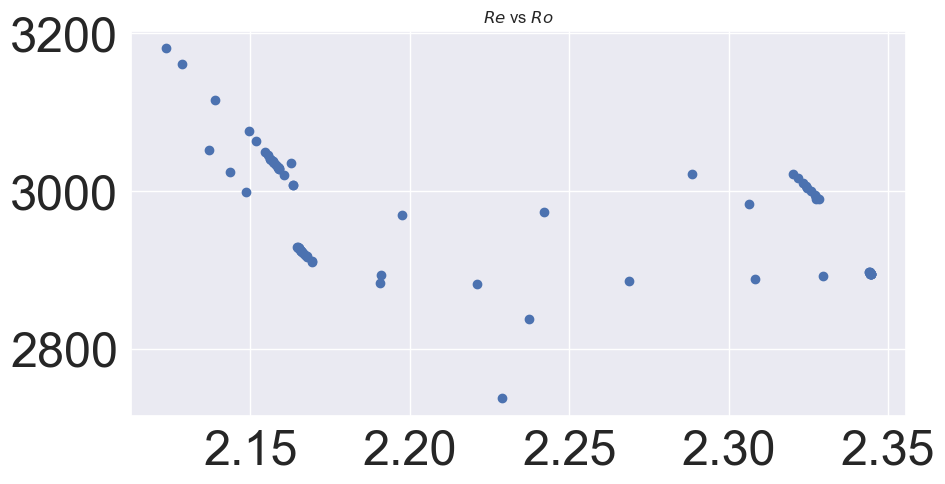

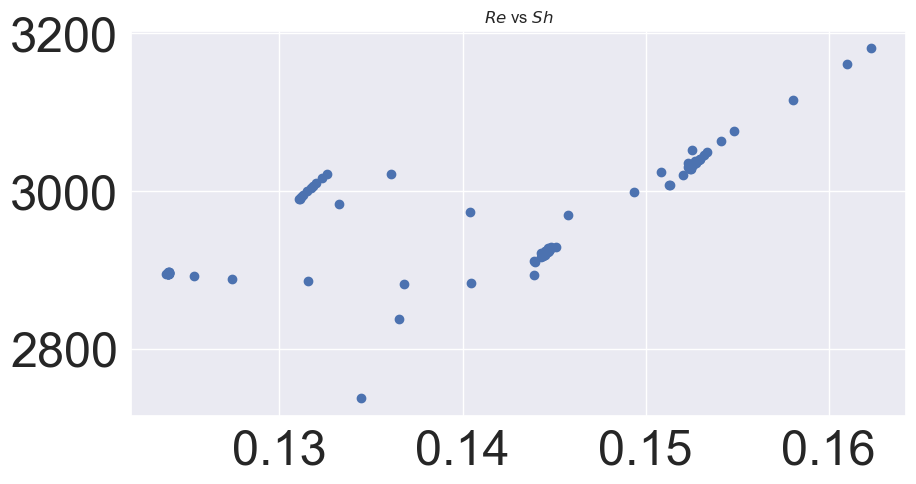

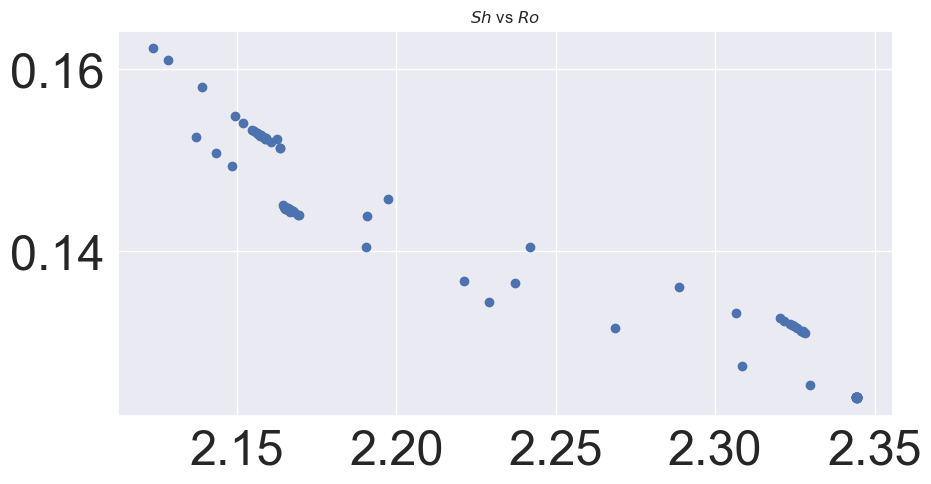

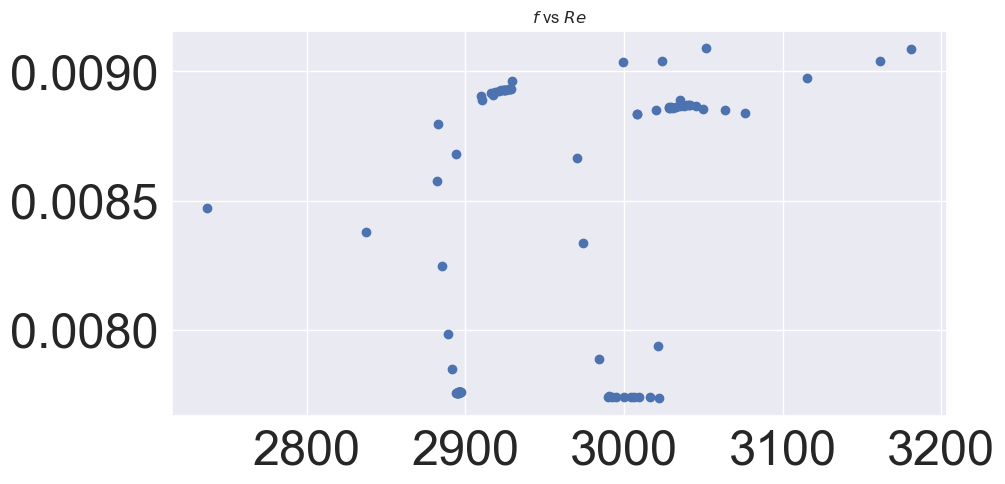

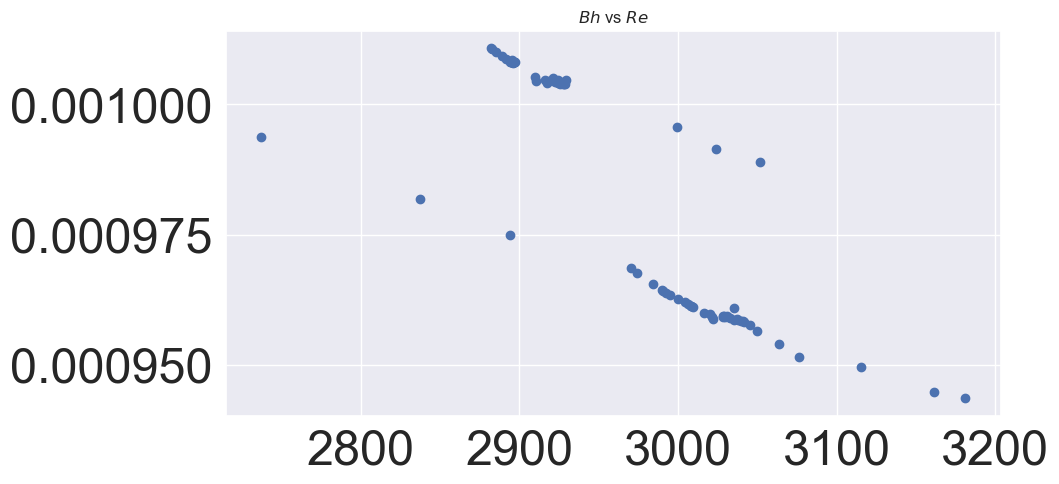

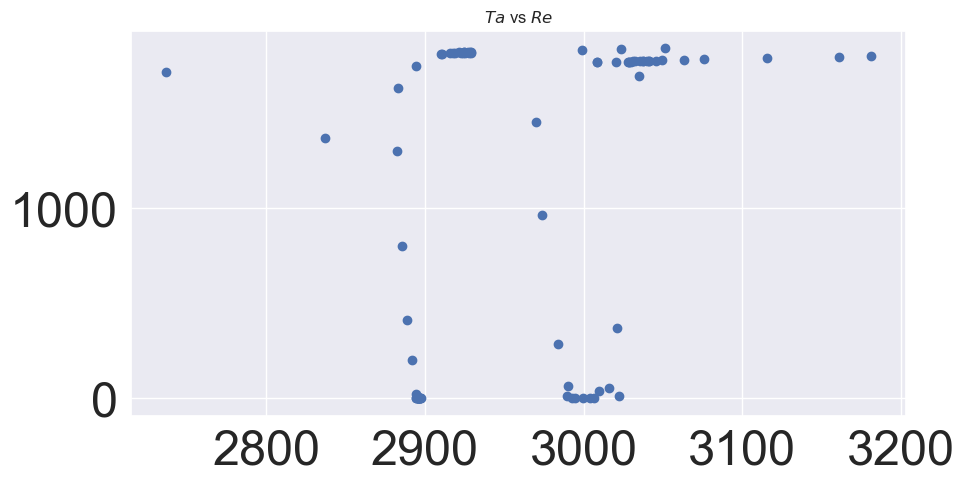

In [25]:

plt.figure(figsize=(10,5))
plt.title(f"$Re$ vs $Ro$")
plt.scatter(all_features_reshaped[:,4], all_features_reshaped[:,0])
plt.show()


plt.figure(figsize=(10,5))
plt.title(f"$Re$ vs $Sh$")
plt.scatter(all_features_reshaped[:,5], all_features_reshaped[:,0])
plt.show()

plt.figure(figsize=(10,5))
plt.title(f"$Sh$ vs $Ro$")
plt.scatter(all_features_reshaped[:,4], all_features_reshaped[:,5])
plt.show()


plt.figure(figsize=(10,5))
plt.title(f"$f$ vs $Re$")
plt.scatter(all_features_reshaped[:,0], all_features_reshaped[:,3])
plt.show()

plt.figure(figsize=(10,5))
plt.title(f"$Bh$ vs $Re$")
plt.scatter(all_features_reshaped[:,0], all_features_reshaped[:,2])
plt.show()


plt.figure(figsize=(10,5))
plt.title(f"$Ta$ vs $Re$")
plt.scatter(all_features_reshaped[:,0], all_features_reshaped[:,1])
plt.show()

In [26]:
with open(FILE_PATH_TRANSIENT_TRAINING_DATA_101_FEATURES, 'wb') as file:
    pickle.dump(training_features, file)

with open(FILE_PATH_TRANSIENT_TRAINING_DATA_101_TARGETS, 'wb') as file:
    pickle.dump(training_targets, file)

with open(FILE_PATH_TRANSIENT_OTHER_VARIABLES_101, 'wb') as file:
    pickle.dump(other_variables, file)